# Fast Video Object Searching


In [1]:
import sys
import platform
import torch
import pandas as pd
import sklearn as sk

has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("NVIDIA/CUDA GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

gpu_device = torch.device(device)

Python Platform: macOS-14.5-arm64-arm-64bit
PyTorch Version: 2.2.2

Python 3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:49:36) [Clang 16.0.6 ]
Pandas 2.2.2
Scikit-Learn 1.4.2
NVIDIA/CUDA GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


# DataSet and DataStore

Six publicly available datasets on pedestrian detection.
- [CalTech](https://data.caltech.edu/records/f6rph-90m20)
- [MOT BenchMark](https://motchallenge.net/)
- [CU HK](https://www.ee.cuhk.edu.hk/~xgwang/PS/dataset.html)
- [PRW](https://zheng-lab.cecs.anu.edu.au/Project/project_prw.html)

The training data for triplet loss is divided into: anchor, positive and negative.
we have total 310 person, so for each person
1 * 50 * 620 * 310
The structure of original dataset is:
- Images
    - Cam1
        - person1
        - person2
        - person3
        - ...
    - Cam2
        - person1
        - person2
        - person3
        - ...
- Sequences
    - Cam1
        - person1
        - person2
        - person3
        - ...
    - Cam2
        - person1
        - person2
        - person3
        - ...

so, it would be like:

```
    for
```

In [2]:
DATA_SIZE = 50000
ANCHOR_DIR = "/Users/JiahaoLiu/ws/thesis/dataset/iLIDS-VID/i-LIDS-VID/images"
SEQUENCE_DIR = "/Users/JiahaoLiu/ws/thesis/dataset/iLIDS-VID/i-LIDS-VID/sequences"
cams = ["cam1", "cam2"]

In [8]:
import os
import random
folders = [folder for folder in os.listdir(os.path.join(os.path.join(SEQUENCE_DIR, "cam1"), "person001"))]
folders.sort()
print(folders[0])

.DS_Store


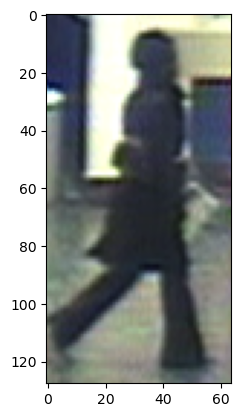

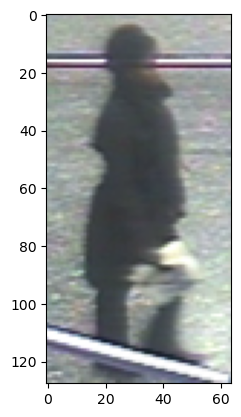

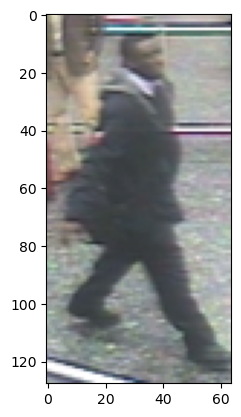

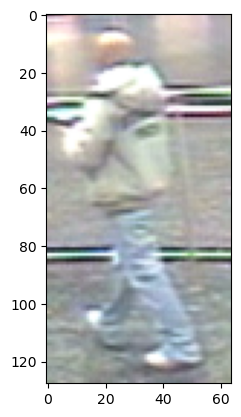

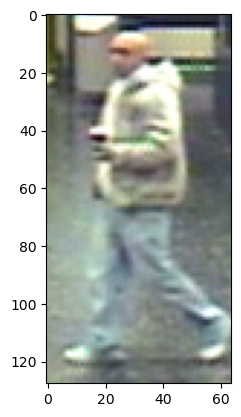

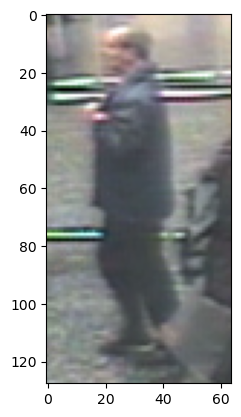

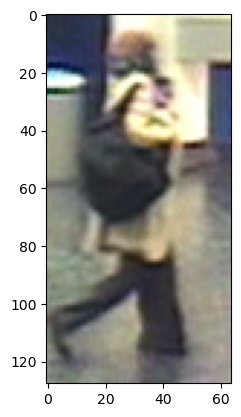

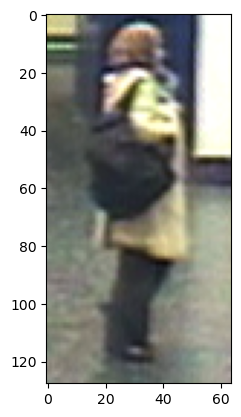

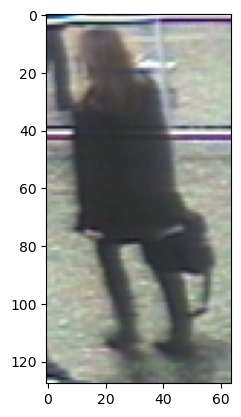

In [18]:
import matplotlib.pyplot as plt
from torchvision.io import read_image
c = 0
for i in range(3):
    try:
        anchor_cam = cams[random.randint(0,len(cams) - 1)]
        anchor_folders = [folder for folder in os.listdir(os.path.join(ANCHOR_DIR, anchor_cam)) if not folder.startswith('.')]
        anchor_person = anchor_folders[random.randint(0, len(anchor_folders) - 1)]
        anchor_path = os.path.join(os.path.join(ANCHOR_DIR, anchor_cam), anchor_person)
        anchor_img = read_image(os.path.join(anchor_path, os.listdir(anchor_path)[0]))
        plt.imshow(anchor_img.permute(1,2,0))
        plt.show()

        positive_cam = cams[random.randint(0,len(cams) - 1)]
        positive_path = os.path.join(os.path.join(SEQUENCE_DIR, positive_cam), anchor_person)
        positive_folders = [folder for folder in os.listdir(positive_path) if not folder.startswith('.')]
        idx = random.randint(0, len(positive_folders) - 1)
        positive_img = read_image(os.path.join(positive_path, positive_folders[idx]))
        plt.imshow(positive_img.permute(1, 2, 0))
        plt.show()
        
        negative_cam = cams[random.randint(0,len(cams) - 1)]
        negative_folders = [folder for folder in os.listdir(os.path.join(SEQUENCE_DIR, negative_cam)) if not folder.startswith('.')] 
        negative_folders.remove(anchor_person)
        negative_person = negative_folders[random.randint(0, len(negative_folders) - 1)]
        negative_path = os.path.join(os.path.join(SEQUENCE_DIR, negative_cam), negative_person)
        negative_person_imgs = [img for img in os.listdir(negative_path) if not img.startswith('.')]
        neg_idx = random.randint(0, len(negative_person_imgs) - 1)
        negative_img = read_image(os.path.join(negative_path, negative_person_imgs[neg_idx]))
        plt.imshow(negative_img.permute(1, 2, 0))
        plt.show()
    except:
        print(negative_cam)
        print(negative_person)
        print(negative_person_imgs[neg_idx])
        print(negative_path)
        break


In [ ]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
from torchvision.io import read_image

class PersonIdentityDataSet(Dataset):
    def __init__(self, anchor_dir, sequence_dir, transform=None, target_transform=None):
        self.anchor_dir = anchor_dir
        self.sequence_dir = sequence_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return 50000

    def __getitem__(self, idx):
        #randomly chose one anchor
        anchor_cam = cams[random.randint(0,len(cams) - 1)]
        anchor_folders = [folder for folder in os.listdir(os.path.join(self.anchor_dir, anchor_cam)) if not folder.startswith('.')]
        anchor_person = anchor_folders[random.randint(0, len(anchor_folders) - 1)]
        anchor_path = os.path.join(os.path.join(self.anchor_dir, anchor_cam), anchor_person)
        anchor_img = read_image(os.path.join(anchor_path, os.listdir(anchor_path)[0]))

        #randomly chose one positive 
        positive_cam = cams[random.randint(0,len(cams) - 1)]
        positive_path = os.path.join(os.path.join(self.sequence_dir, positive_cam), anchor_person)
        positive_folders = [folder for folder in os.listdir(positive_path) if not folder.startswith('.')]
        idx = random.randint(0, len(positive_folders) - 1)
        positive_img = read_image(os.path.join(positive_path, positive_folders[idx]))

        #randomly chose one negative
        negative_cam = cams[random.randint(0,len(cams) - 1)]
        negative_folders = [folder for folder in os.listdir(os.path.join(self.sequence_dir, negative_cam)) if not folder.startswith('.')] 
        negative_folders.remove(anchor_person)
        negative_person = negative_folders[random.randint(0, len(negative_folders) - 1)]
        negative_path = os.path.join(os.path.join(self.sequence_dir, negative_cam), negative_person)
        negative_person_imgs = [img for img in os.listdir(negative_path) if not img.startswith('.')]
        neg_idx = random.randint(0, len(negative_person_imgs) - 1)
        negative_img = read_image(os.path.join(negative_path, negative_person_imgs[neg_idx]))
        return anchor_img, positive_img, negative_img